In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import shutil
import datetime

%load_ext tensorboard

In [ ]:
datasetFolderName='/content/drive/MyDrive/Colab Notebooks/Data Pitaya(Validasi)'
sourceFiles=[]
classLabels=['Bercak Merah', 'Busuk Batang', 'Busuk Hitam', 'Kudis', 'Mosaik']

In [ ]:
def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    # memasukkan listdir dari folder asal kedalam variabel array sourceFiles
    sourceFiles=os.listdir(source)

    # mengecek apakah ada data pada variabel sourceFiles
    if(len(sourceFiles)!=0):
        # jika ada data, kemudian menghitung total data yang akan di split, yaitu total sourceFiles x splitRate
        # dan sisimpan pada variabel transferFileNumbers
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        # kemudian mengambil index data secara random/acak dengan jumlah data sesuai variabel transferFileNumbers 
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)

        # kemudian memindahkan data citra sesuai indexnya dari folder source ke folder dest
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)

In [ ]:
# Pertama, periksa apakah folder test kosong atau tidak,
# jika tidak transfer semua file yang ada ke folder train
transferAllClassBetweenFolders('test', 'train', 1.0)

# Sekarang, bagi data train ke dalam folder test.
transferAllClassBetweenFolders('train', 'test', 0.20)

In [ ]:
X=[]
Y=[]
 
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        if(folderName==classLabels[0]):
            Y.append(0)
        elif(folderName==classLabels[1]):
            Y.append(1)
        elif(folderName==classLabels[2]):
            Y.append(2)
        elif(folderName==classLabels[3]):
            Y.append(3)
        else:
            Y.append(4)
 
# Atur nama file dan label kelas dalam variabel X dan Y.
prepareNameWithLabels(classLabels[0])
prepareNameWithLabels(classLabels[1])
prepareNameWithLabels(classLabels[2])
prepareNameWithLabels(classLabels[3])       
prepareNameWithLabels(classLabels[4])       
 
X=np.asarray(X)
Y=np.asarray(Y)
 
print(X)
print(Y)

In [ ]:
train_path = datasetFolderName+'/train/'
validation_path = datasetFolderName+'/validation/'
test_path = datasetFolderName+'/test/'
 
num_class = len(classLabels)
print(num_class)

5


In [ ]:
model = Sequential()
 
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)


In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

In [ ]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.2,
        shear_range = 0.2,
        horizontal_flip = True,
)

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
skf.get_n_splits(X, Y)
foldNum = 0
epoch = 5
 
for train_index, val_index in skf.split(X, Y):
    # Pindahkan semua data dari folder validation ke folder train
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Hasil untuk Fold ke ",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Pindahkan data sesuai index dan fold dari folder train ke validation
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
        elif(Y_val[eachIndex]==2):
            classLabel=classLabels[2]
        elif(Y_val[eachIndex]==3):
            classLabel=classLabels[3]
        else:
            classLabel=classLabels[4]   
        #Kemudian, pindahkan gambar validasi ke folder validation
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    #preprocessing
    train_generator = datagen.flow_from_directory(
        directory = train_path,
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'categorical',
    )
 
    val_generator = datagen.flow_from_directory(
            directory = validation_path,
            target_size = (150, 150),
            batch_size = 16,
            class_mode = 'categorical',
    )   
   
    # fit model
    history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator,
        validation_steps = len(val_generator),
        epochs = epoch,
        verbose = 1,
    )

In [ ]:
# Save Model
base_path = "/content/drive/My Drive/Colab Notebooks/model"
project_name = "pitaya"
model_name = "pitaya_modelKFold5_Epoch5_validasi.h5"
model_path = os.path.join(base_path, project_name, model_name)
model.save(model_path, include_optimizer = False)

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,average='weighted')
    f1Score = f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("F1Score : {}".format(f1Score))

In [ ]:
# =============TESTING============
from tensorflow.keras.models import load_model

# load model
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/model/pitaya/pitaya_modelKFold5_Epoch5_validasi.h5'
model = load_model(MODEL_PATH, compile = True)

test = '/content/drive/MyDrive/Colab Notebooks/Data Pitaya(Validasi)/test'

test_generator = datagen.flow_from_directory(
        directory = test,
        target_size=(150, 150),
        batch_size = 1,
        class_mode = 'categorical',
        shuffle = False
) 

predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print("\nHasil Sebenarnya Data Test\n{}".format(true_classes))
print("\nHasil Prediksi Data Test\n{}\n".format(yPredictions))
my_metrics(true_classes, yPredictions)

In [ ]:
# =================================================================================================================

In [ ]:
# Ending

In [ ]:
# ===================================================================================================================

In [ ]:
# def my_metrics(y_true, y_pred):
    # accuracy = accuracy_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred,average='weighted')
    # f1Score = f1_score(y_true, y_pred, average='weighted') 
    # cm = confusion_matrix(y_true, y_pred)
    # print("Accuracy  : {}".format(accuracy))
    # print("Precision : {}".format(precision))
    # print("F1Score : {}".format(f1Score))
    # print("Confusion Matrix : \n{}".format(cm))
    # return accuracy, precision, f1Score

# print("============== HASIL TESTING MODEL ==============\nTotal {} Citra dari {} Kategori".format(len(test_generator), num_class))
# print("Kategori 0 - 5 : {}".format(classLabels))
# testAcc, testPrec, testFScore, testCm = my_metrics(true_classes, yPredictions)
# print("\nHasil Sebenarnya Data Test\n{}".format(true_classes))
# print("\nHasil Prediksi Data Test\n{}\n".format(yPredictions))
# my_metrics(true_classes, yPredictions)

In [ ]:
from tensorboard import notebook
notebook.list()

In [ ]:
notebook.display(port=6006, height=1000) 

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
image_path= r"/content/drive/MyDrive/Colab Notebooks/Data Pitaya/test/Busuk Batang/DSC07657.jpg"
img = image.load_img(image_path, target_size=(150, 150))  
input = image.img_to_array(img)                           
input = input.reshape((1,) + input.shape)                   
input /= 255.0

(1, 150, 150, 3)


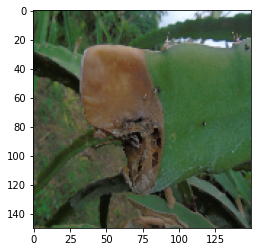

In [ ]:

image_path = '/content/drive/MyDrive/Colab Notebooks/Data Pitaya/test/Busuk Batang/DSC07657.jpg'

img = image.load_img(image_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

# Print image tensor shape
print(img_tensor.shape)

# Print image
plt.imshow(img_tensor[0])
plt.show()


In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

In [ ]:
feature_maps = feature_map_model.predict(img_tensor)

In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d is =======>> (1, 148, 148, 16)
The shape of the max_pooling2d is =======>> (1, 74, 74, 16)
The shape of the conv2d_1 is =======>> (1, 72, 72, 32)
The shape of the max_pooling2d_1 is =======>> (1, 36, 36, 32)
The shape of the conv2d_2 is =======>> (1, 34, 34, 64)
The shape of the max_pooling2d_2 is =======>> (1, 17, 17, 64)
The shape of the conv2d_3 is =======>> (1, 15, 15, 64)
The shape of the max_pooling2d_3 is =======>> (1, 7, 7, 64)


In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
  global image_belt
  if len(feature_map.shape) == 4 :
      k = feature_map.shape[-1]  
      size = feature_map.shape[1]
      # print(k)
      # print(size)
      # print("")
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        scale = 20 / k
        plt.figure(figsize=(scale * k, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow( feature_image, aspect='auto')


In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = tf.keras.models.Model(model.input, layer_outputs)
activations = activation_model.predict(img_tensor)

for a in range(len(activations)) :
  layer_activation = activations[a]
  print(layer_activation.shape)

  for i in range(a):
    plt.matshow(layer_activation[0, :, :, i], cmap ='viridis')


In [ ]:
layer_names = []

for layer in model.layers[:8]:
  layer_names.append(layer.name)
  print(layer_names)


In [ ]:
!pip install keract

In [ ]:
from keract import display_activations, get_activations, display_heatmaps
from tensorflow.keras.models import load_model

MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/model/pitaya/pitaya_modelKFold5_Epoch5.h5'
model = load_model(MODEL_PATH, compile = False)

lay_activations = get_activations(model, img_tensor)

In [ ]:
display_activations(lay_activations, save=True)

conv2d_input (1, 150, 150, 3) 
conv2d (1, 148, 148, 16) 
max_pooling2d (1, 74, 74, 16) 
conv2d_1 (1, 72, 72, 32) 
max_pooling2d_1 (1, 36, 36, 32) 
conv2d_2 (1, 34, 34, 64) 
max_pooling2d_2 (1, 17, 17, 64) 
conv2d_3 (1, 15, 15, 64) 
max_pooling2d_3 (1, 7, 7, 64) 
flatten (1, 3136) 
dense (1, 256) 
dropout (1, 256) 
dense_1 (1, 6) 


In [ ]:
display_heatmaps(lay_activations, img_tensor, save=False)


In [ ]:
test_generator = datagen.flow_from_directory(
    directory = test_path,
    target_size=(150, 150),
    batch_size=1,
    save_to_dir="/content/drive/MyDrive/Colab Notebooks/Data Pitaya/output-preprocessing",
    save_prefix="",
    save_format='png',
    class_mode = 'categorical',
    shuffle = False
) 

for _ in range(1):
    img, label = test_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()